# Text Recognition with CTC

In [22]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists

In [23]:
import ctc_utils as utils
from importlib import reload 
import warnings

# Ensure we have always the latest state and 
# not the last import in memory
reload(utils)

<module 'ctc_utils' from '/Users/jpec/Prog/OCRpyMAN/notebooks/text_recognition/ctc_utils.py'>

In [24]:
img_size = (32, 128)
full_df = pd.read_pickle('../../pickle/df.pickle')
print("Length: ", len(full_df))
df = full_df[['transcription', 'word_img_path', 'word_id']]
df['word_img_path'] = df.word_img_path.apply(lambda x: '../' + x)
df.head(3)

Length:  96420


/var/folders/45/1rh915g935nggkhvq3fhbn180000gn/T/ipykernel_15247/1927137089.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_img_path'] = df.word_img_path.apply(lambda x: '../' + x)


,transcription,word_img_path,word_id
0,A,../../data/words/a01/a01-000u/a01-000u-00-00.png,a01-000u-00-00
1,MOVE,../../data/words/a01/a01-000u/a01-000u-00-01.png,a01-000u-00-01
2,to,../../data/words/a01/a01-000u/a01-000u-00-02.png,a01-000u-00-02


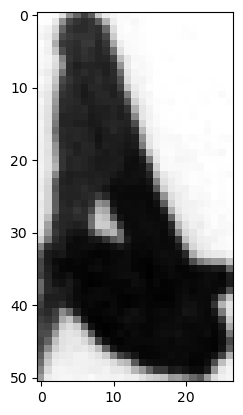

In [25]:
plt.imshow(plt.imread(df.iloc[0].word_img_path), cmap='gray');

In [26]:
import string

char_list = list(string.ascii_letters)+[' '] 

def extract_allowed_chars_from_string(char_list, str):
    res = ''
    for letter in str:
        if letter in char_list:
            res += letter
    return res

df['clean_trans'] = df.transcription.apply(lambda x: extract_allowed_chars_from_string(char_list, x))
df.head()

/var/folders/45/1rh915g935nggkhvq3fhbn180000gn/T/ipykernel_15247/2264966378.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_trans'] = df.transcription.apply(lambda x: extract_allowed_chars_from_string(char_list, x))


,transcription,word_img_path,word_id,clean_trans
0,A,../../data/words/a01/a01-000u/a01-000u-00-00.png,a01-000u-00-00,A
1,MOVE,../../data/words/a01/a01-000u/a01-000u-00-01.png,a01-000u-00-01,MOVE
2,to,../../data/words/a01/a01-000u/a01-000u-00-02.png,a01-000u-00-02,to
3,stop,../../data/words/a01/a01-000u/a01-000u-00-03.png,a01-000u-00-03,stop
4,Mr.,../../data/words/a01/a01-000u/a01-000u-00-04.png,a01-000u-00-04,Mr


In [27]:
print("Taille avant nettoyage:", len(df))
df = df[(df['clean_trans'] != "") & (df['clean_trans'] == df['transcription'])]
# df = df[df['clean_trans'] != ""]
print("Taille après nettoyage:", len(df))

Taille avant nettoyage: 96420
Taille après nettoyage: 82267


In [7]:
df.transcription.apply(lambda x: len(x)).max()

17

## Model Doc

### CNN Part


The idea here is to cut our image into several features (could be interpreted as smaller areas of the picture).

<img src="imgs/cnn_result.png" />

To do so, we ill use a succession of 
- **Convolution** to extract
- **Batch Normalization** to prevent our model from overfitting (equivalent of Dropout) 

#### Batch normalization

TLDR: Solve **internal covariate shift** and simplify 

**Normalization** is a procedure to change the value of the numeric variable in the dataset to a typical scale, without misshaping contrasts in the range of value.

**Batch normalization** is a technique for training very deep neural networks that normalizes the contributions to a layer for every mini-batch.

In neural networks, the output of the first layer feeds into the second layer, the output of the second layer feeds into the third, and so on. When the parameters of a layer change, so does **the distribution of inputs to subsequent layers**.

> We define Internal Covariate Shift as the change in the distribution of network activations due to the change in network parameters during training.

These shifts in input distributions can be problematic for neural networks, especially deep neural networks that could have a large number of layers.

Batch normalization is a method intended to mitigate internal covariate shift for neural networks.

<img src="imgs/batch_normalization.jpeg" />

This has the impact of settling the learning process and drastically decreasing the number of training epochs required to train deep neural networks.

Sources: 
- https://machinelearning.wtf/terms/internal-covariate-shift/
- https://towardsdatascience.com/batch-normalisation-in-deep-neural-network-ce65dd9e8dbf#:~:text=Batch%20normalization%20solves%20a%20major,you%20can%20often%20remove%20dropout.
- https://towardsdatascience.com/understanding-dataset-shift-f2a5a262a766

#### Conv

<img src="imgs/conv_padding.gif" />

- Padding '**valid**' is the first figure. The filter window stays inside the image. When padding == "VALID", there can be a loss of information. Generally, elements on the right and the bottom of the image tend to be ignored. How many elements are ignored depends on the size of the kernel and the stride.

- Padding '**same**' is the third figure. The output is the same size.


#### Pooling/Flattening

**Pooling** is the process of merging. So it’s basically for the purpose of **reducing the size of the data**.

<img src="imgs/pooling_flattening.png" />

**Flattening** is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector.

Sources: 

- https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480

## Model build

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout


hidden_layer_count = 256

def build_sequential_model():
    model = tf.keras.Sequential()
    # Layer 1
    # (None, 32, 128, 64)
    model.add(Conv2D(
            filters=32,
            kernel_size=(5,5),
            padding='SAME',
            input_shape = (img_size[0], img_size[1], 1)
        )
    )
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 2
    # (None, 16, 64, 64)
    model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 3
    # (None, 8, 32, 128 -> nb conv filters)
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))


    # Layer 4
    # (None, 4, 32, 128)
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    # Layer 5
    # (None, 2, 32, 128)
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))
    # (None, 1, 32, 256)
    return model
    
# model = build_sequential_model()
# model.summary()

At this point, we have cut our entry image into X smaller parts. Those parts can be read as a time serie.

Indeed, there is a strong connection between one part and the one coming after by construction (a word is a succession of letters).

We can therefore make use of a **RNN** now in our model.

NB: a part does not correspond exactly to a letter, it is more the idea behind it. It could be interesting to see the importance of the size of each part (number of cuts).


### RNN part

In [32]:
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Lambda

model = build_sequential_model()
model.add(Lambda(lambda x: tf.squeeze(x, axis=1)))
# (None, 32, 256)
# Bidirectionnal RNN
model.add(Bidirectional(GRU(hidden_layer_count, return_sequences=True)))
model.add(Dense(len(char_list) + 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 128, 32)       832       
                                                                 
 batch_normalization_5 (Batc  (None, 32, 128, 32)      128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_6 (Batc  (None, 16, 64, 64)      

```
NotImplementedError: Cannot convert a symbolic Tensor (bidirectional_3/forward_gru_3/strided_slice:0) to a numpy array.
```



TODO LSTM could be a good idea ? 

https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c
https://distill.pub/2017/ctc/

## Connectionist Temporal Classification

### Encoder/Decoder

In [28]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df.word_img_path, df.clean_trans.values, test_size=0.1, random_state=42)

print(y_train.shape)
print(y_test.shape)
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

(74040,)
(8227,)


In [29]:
@tf.function
def preprocess_entries(x, y):
    return (utils.preprocess(x, data_augmentation=False, scale=0.8, is_threshold=True, with_edge_detection=True), y)

@tf.function
def preprocess_batch(x_b, y_b):
    return (x_b, utils.encode_labels(y_b, char_list))

dataset_train = dataset_train.map(preprocess_entries).batch(64).map(preprocess_batch)
dataset_test = dataset_test.map(preprocess_entries).batch(64).map(preprocess_batch)

In [30]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, reduction=tf.keras.losses.Reduction.SUM, name='ctc'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=-1)
        return tf.reduce_mean(loss)

In [33]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=CTCLoss(), optimizer=optimizer)
history = model.fit(
    dataset_train,
    validation_data=dataset_test,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ],
    epochs=10
)

Epoch 1/10
1157/1157 [==============================] - ETA: 0s - loss: 11.4225

INFO:tensorflow:Assets written to: tmp_model/assets


INFO:tensorflow:Assets written to: tmp_model/assets


1157/1157 [==============================] - 592s 508ms/step - loss: 11.4225 - val_loss: 7.3652
Epoch 2/10
1157/1157 [==============================] - ETA: 0s - loss: 5.5082

INFO:tensorflow:Assets written to: tmp_model/assets


INFO:tensorflow:Assets written to: tmp_model/assets


1157/1157 [==============================] - 575s 497ms/step - loss: 5.5082 - val_loss: 6.5917
Epoch 3/10
1157/1157 [==============================] - ETA: 0s - loss: 3.8682

INFO:tensorflow:Assets written to: tmp_model/assets


INFO:tensorflow:Assets written to: tmp_model/assets


1157/1157 [==============================] - 568s 491ms/step - loss: 3.8682 - val_loss: 4.1283
Epoch 4/10
1157/1157 [==============================] - ETA: 0s - loss: 3.0688

INFO:tensorflow:Assets written to: tmp_model/assets


INFO:tensorflow:Assets written to: tmp_model/assets


1157/1157 [==============================] - 569s 492ms/step - loss: 3.0688 - val_loss: 3.3501
Epoch 5/10
1157/1157 [==============================] - ETA: 0s - loss: 2.5729

INFO:tensorflow:Assets written to: tmp_model/assets


INFO:tensorflow:Assets written to: tmp_model/assets


1157/1157 [==============================] - 570s 493ms/step - loss: 2.5729 - val_loss: 3.3352
Epoch 6/10
1157/1157 [==============================] - ETA: 0s - loss: 2.2152

INFO:tensorflow:Assets written to: tmp_model/assets


INFO:tensorflow:Assets written to: tmp_model/assets


1157/1157 [==============================] - 572s 494ms/step - loss: 2.2152 - val_loss: 3.1068
Epoch 7/10
1157/1157 [==============================] - ETA: 0s - loss: 1.9361

INFO:tensorflow:Assets written to: tmp_model/assets


INFO:tensorflow:Assets written to: tmp_model/assets


1157/1157 [==============================] - 573s 495ms/step - loss: 1.9361 - val_loss: 3.0633
Epoch 8/10
1157/1157 [==============================] - ETA: 0s - loss: 1.7030

INFO:tensorflow:Assets written to: tmp_model/assets


INFO:tensorflow:Assets written to: tmp_model/assets


1157/1157 [==============================] - 570s 493ms/step - loss: 1.7030 - val_loss: 2.7325
Epoch 9/10
1157/1157 [==============================] - 561s 484ms/step - loss: 1.5008 - val_loss: 2.8763
Epoch 10/10
1157/1157 [==============================] - 567s 490ms/step - loss: 1.3220 - val_loss: 3.1200


In [60]:
with open('history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
with open('history.pickle', "rb") as file_pi:
    history = pickle.load(file_pi)

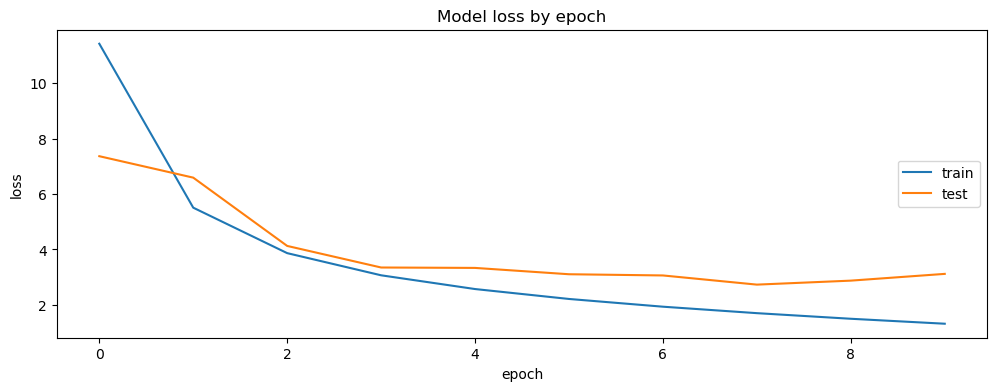

In [62]:
plt.figure(figsize=(12,4))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [34]:
y_pred = model.predict(dataset_test)
predicted_transcriptions = utils.greedy_decoder(y_pred, char_list)
list(zip(predicted_transcriptions, y_test[:10]))

129/129 [==============================] - 21s 157ms/step


[('I', 'I'),
 ('his', 'his'),
 ('Retwen', 'between'),
 ('become', 'become'),
 ('conventional', 'conventional'),
 ('ste', 'she'),
 ('estallihing', 'establishing'),
 ('ne', 'new'),
 ('presswe', 'pressure'),
 ('Natt', 'Nato')]

TODO
- Add english language corrector as an option
- See with different slicing (not 32)


In [55]:
model.save('ctc_model_fit_10')

INFO:tensorflow:Assets written to: ctc_model_fit_10/assets


INFO:tensorflow:Assets written to: ctc_model_fit_10/assets


In [56]:
model = tf.keras.models.load_model("ctc_model_fit_10", custom_objects={"CTCLoss": CTCLoss})

In [57]:
print(model.history)

None


In [36]:
eval_data = list(zip(y_test, predicted_transcriptions))

In [37]:
eval_df = pd.DataFrame(data=np.array(eval_data), columns=['real', 'predicted'])
eval_df.head()

,real,predicted
0,I,I
1,his,his
2,between,Retwen
3,become,become
4,conventional,conventional


In [38]:
len(eval_df)

8227

# Evaluation

https://towardsdatascience.com/evaluating-ocr-output-quality-with-character-error-rate-cer-and-word-error-rate-wer-853175297510

## Character Error Rate (CER)

In [39]:
print(utils.levenshtein_distance("Toto", "Tut"))
print(utils.levenshtein_distance("Bonjour", "Bonnrouuj"))

2
4


In [40]:
eval_df['cer'] = [utils.evaluate_character_level_accuracy(row.real, row.predicted) for index, row in eval_df.iterrows()]

In [41]:
eval_df.head()

,real,predicted,cer
0,I,I,1.000000
1,his,his,1.000000
2,between,Retwen,0.714286
3,become,become,1.000000
4,conventional,conventional,1.000000


In [42]:
print("Notre modèle a une précision par mot de", eval_df['cer'].mean())

Notre modèle a une précision par mot de 0.8281169374566171


## Word Error Rate (WER)

In [85]:
df.head()

,transcription,word_img_path,word_id,clean_trans
0,A,../../data/words/a01/a01-000u/a01-000u-00-00.png,a01-000u-00-00,A
1,MOVE,../../data/words/a01/a01-000u/a01-000u-00-01.png,a01-000u-00-01,MOVE
2,to,../../data/words/a01/a01-000u/a01-000u-00-02.png,a01-000u-00-02,to
3,stop,../../data/words/a01/a01-000u/a01-000u-00-03.png,a01-000u-00-03,stop
5,Gaitskell,../../data/words/a01/a01-000u/a01-000u-00-05.png,a01-000u-00-05,Gaitskell
